<a href="https://colab.research.google.com/github/abhinav70291/TechnicalAnalysis-for-intra-day-trading/blob/main/Technical_Analysis_rectified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install -q --upgrade ipywidgets matplotlib
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, SelectMultiple, SelectionRangeSlider
from datetime import datetime

In [13]:
df=pd.read_csv("/content/Manappuram_10minute.csv")
df.tail(5)

,Date,Open,High,Low,Close,Volume
2492,2020-04-28T14:35:00,123.90,124.25,123.7,124.15,289726
2493,2020-04-28T14:45:00,124.15,125.80,124.1,125.80,1706683
2494,2020-04-28T14:55:00,125.80,125.80,125.8,125.80,145240
2495,2020-04-28T15:05:00,125.80,131.50,125.8,130.85,3162404
2496,2020-04-28T15:15:00,130.95,130.95,129.6,129.75,221556


In [14]:
df.describe()

,Open,High,Low,Close,Volume
count,2497.000000,2497.000000,2497.000000,2497.000000,2.497000e+03
mean,141.437765,142.033280,140.847016,141.436063,2.516820e+05
std,35.841566,35.724133,35.935600,35.827102,3.632527e+05
min,77.800000,79.250000,74.250000,78.000000,5.013000e+03
25%,106.000000,106.500000,105.450000,106.050000,9.235000e+04
50%,155.750000,156.050000,154.900000,155.750000,1.672910e+05
75%,174.050000,174.500000,173.400000,173.900000,2.971630e+05
max,194.200000,194.700000,191.500000,192.150000,1.239266e+07


In [15]:
# Converting Date column into datetime dftype
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


# **State the Values you want to consider for this backtesting and technical analysis**

In [135]:
# Run the loop and find the optimal parameters
starting_capital = 10000  # Starting capital in your currency
stop_loss = 0.02  # Stop loss level (2% in this case)
upper_cap = 1000  # Upper investment cap in your currency
lower_cap = 100  # Lower investment cap in your currency
transaction_cost = 0.001  # Transaction cost (0.1% in this case)
leverage = 1 # Leverage (1x in this case meaning no leverage, just the original capital)
volume_percentage = 0.001  # Minimum average daily volume

In [91]:
# Initialize a DataFrame to store metrics for each parameter
metrics_df = pd.DataFrame(columns=['indicator', 'hit_rate', 'profit_factor', 'sharpe_ratio', 'max_drawdown', 'total_profit', 'profit_percentage', 'avg_win_to_avg_loss_ratio', 'sortino_ratio', 'num_trades'])

# **Defining ALL indicator functions  here**

In [29]:
# calculates SMA using "n" as the rolling window size
def ma_calc(df, n):
  df["sma"] = df.Close.rolling(window=n).mean()
  return df

# calculates SMA using "m" and "n" as the rolling window size
def longshort_ma_calc(df, m, n):
  df["sma_short"] = df.Close.rolling(window=min(m,n)).mean()
  df["sma_long"] = df.Close.rolling(window=max(m,n)).mean()
  return df

# calculates EMA using "n" as the rolling window size
def ema_calc(df, n):
  df["ema"] = df.Close.ewm(span=n, adjust=False).mean()
  return df


def longshort_ema_calc(df, m, n):
  df["ema_short"] = df.Close.ewm(span=min(m,n), adjust=False).mean()
  df["ema_long"] = df.Close.ewm(span=max(m,n), adjust=False).mean()
  return df

# calculates RSI using "n" as the lookback period
def rsi_calc(df, n):
  df['rsi'] = 100 - (100 / (1 + df['Close'].diff().apply(lambda x: x if x > 0 else 0).rolling(window=n).mean() / df['Close'].diff().apply(lambda x: -x if x < 0 else 0).rolling(window=n).mean()))
  return df

# calculates OBV
def obv_calc(df):
  df['obv'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
  return df

def bb_calc(df, n):
  df["sma"] = df.Close.rolling(window=n).mean()
  df["std"] = df.Close.rolling(window=n).std()
  df["upper_bb"] = df["sma"] + (2 * df["std"])
  df["lower_bb"] = df["sma"] - (2 * df["std"])
  return df

# Volume weighted average price
def vwap_calc(df):
    df['vwap'] = (df['Volume'] * df['Close']).cumsum() / df['Volume'].cumsum()
    return df

# Supertrend Indicator
def supertrend_calc(df, period, multiplier):
    # Calculate basic upper and lower bands
    df['hl_avg'] = (df['High'] + df['Low']) / 2
    df['range'] = df['High'] - df['Low']
    df['upper_band'] = df['hl_avg'] + multiplier * df['range']
    df['lower_band'] = df['hl_avg'] - multiplier * df['range']

    # Calculate final upper and lower bands
    df['upper_band_final'] = np.where((df['upper_band'] < df['upper_band'].shift(1)) | (df['Close'] > df['upper_band'].shift(1)), df['upper_band'], df['upper_band'].shift(1))
    df['lower_band_final'] = np.where((df['lower_band'] > df['lower_band'].shift(1)) | (df['Close'] < df['lower_band'].shift(1)), df['lower_band'], df['lower_band'].shift(1))

    # Calculate Supertrend
    df['supertrend'] = np.where(df['Close'] <= df['upper_band_final'], df['upper_band_final'], df['lower_band_final'])
    df['supertrend'] = np.where(df['Close'] >= df['lower_band_final'], df['lower_band_final'], df['supertrend'])

    return df

# calculates Average Directional Index (ADX)
def adx_calc(df, n):
    df['hl_diff'] = df['High'] - df['Low']
    df['hc_diff'] = abs(df['High'] - df['Close'].shift(1))
    df['lc_diff'] = abs(df['Low'] - df['Close'].shift(1))
    df['tr'] = df[['hl_diff', 'hc_diff', 'lc_diff']].max(axis=1)
    df['+dm'] = np.where((df['High'] > df['High'].shift(1)) & (df['High'] - df['High'].shift(1) > df['Low'].shift(1) - df['Low']), df['High'] - df['High'].shift(1), 0)
    df['-dm'] = np.where((df['Low'] < df['Low'].shift(1)) & (df['High'].shift(1) - df['High'] < df['Low'].shift(1) - df['Low']), df['Low'].shift(1) - df['Low'], 0)
    df['tr_ema'] = df['tr'].ewm(span=n, adjust=False).mean()
    df['+dm_ema'] = df['+dm'].ewm(span=n, adjust=False).mean()
    df['-dm_ema'] = df['-dm'].ewm(span=n, adjust=False).mean()
    df['+di'] = (df['+dm_ema'] / df['tr_ema']) * 100
    df['-di'] = (df['-dm_ema'] / df['tr_ema']) * 100
    df['dx'] = (abs(df['+di'] - df['-di']) / (df['+di'] + df['-di'])) * 100
    df['adx'] = df['dx'].rolling(window=n).mean()

    return df

# calculates MACD
def macd_calc(df, short_n, long_n, signal_n):
    df['ema_short'] = df['Close'].ewm(span=short_n, adjust=False).mean()
    df['ema_long'] = df['Close'].ewm(span=long_n, adjust=False).mean()
    df['macd_line'] = df['ema_short'] - df['ema_long']
    df['signal_line'] = df['macd_line'].ewm(span=signal_n, adjust=False).mean()
    df['macd_histogram'] = df['macd_line'] - df['signal_line']

    return df


# **Backtesting starts from here**
**Our Indicators for consideration here are -**

(i)  SMA

(ii) Short term SMA and Long term SMA

(iii) EMA

(iv) Short term EMA and Long term EMA

(v) RSI

(vi) Average Directional Index

(vii)  Bollinger Bands



**SMA**

In [144]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

def backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage):
  df = ma_calc(df, n)
  in_position = False
  daily_profits = []
  capital = starting_capital
  net_profit_loss = 0
  num_trades = 0
  wins = []
  losses = []

  for day in np.unique(df.index.date):
    df_day = df[df.index.date == day]
    profits = []
    for index, row in df_day.iterrows():
        volume_limit = row.Volume * volume_percentage  # Set volume limit as a percentage of daily volume
        if not in_position:
            if row.Close > row.sma and row.Volume > volume_limit:
                buyprice = row.Close
                investment = min(max(capital * volume_percentage, lower_cap), upper_cap)  # Calculate the investment amount
                shares_to_trade = investment / buyprice  # Calculate the number of shares to be traded
                if investment > capital * leverage:
                    continue  # Skip if not enough capital
                capital -= investment * (1 + transaction_cost)  # Deduct investment and transaction cost from capital
                in_position = True

        if in_position:
            if row.Close < row.sma or row.Close < buyprice * (1 - stop_loss):
                profit = (row.Close - buyprice) * shares_to_trade  # Calculate profit
                profits.append(profit)
                capital += (investment + profit) * (1 - transaction_cost)  # Add selling proceeds after transaction cost to capital
                in_position = False
                num_trades += 1
                if profit > 0:
                    wins.append(profit)
                else:
                    losses.append(profit)

    daily_profits.append(sum(profits))

  # Calculate metrics
  daily_profits = pd.Series(daily_profits)
  hit_rate = (daily_profits > 0).mean()
  profit_factor = daily_profits[daily_profits > 0].sum() / -daily_profits[daily_profits < 0].sum()
  sharpe_ratio = np.sqrt(len(df)) * daily_profits.mean() / daily_profits.std()
  sortino_ratio = np.sqrt(len(df)) * daily_profits.mean() / daily_profits[daily_profits < 0].std()
  max_drawdown = np.min(daily_profits)
  total_profit = capital - starting_capital
  profit_percentage = (total_profit / starting_capital) * 100
  avg_win_to_avg_loss_ratio = np.mean(wins) / np.mean(losses)

  return hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades

# Initialize a dictionary to store metrics for each parameter
metrics_dict = {}

for n in range(2, 19):
  hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades = backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage)
  print(f"For parameter: {n}, Hit Rate: {hit_rate}, Profit Factor: {profit_factor}, Sharpe Ratio: {sharpe_ratio}, Max Drawdown: {max_drawdown}, Total Profit: {total_profit}, Profit Percentage: {profit_percentage}%, Average Win to Average Loss ratio: {avg_win_to_avg_loss_ratio}, Sortino Ratio: {sortino_ratio}, Number of Trades: {num_trades}")
  metrics_dict[n] = (hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades)

# Find the parameter with maximum Sharpe Ratio
max_sharpe_param = max(metrics_dict, key=lambda x: metrics_dict[x][2])
print(f"The parameter with maximum Sharpe Ratio is: {max_sharpe_param}")

# Add the feature with optimized value
df = ma_calc(df, max_sharpe_param)


For parameter: 2, Hit Rate: 0.5, Profit Factor: 0.754711385073121, Sharpe Ratio: -4.911179130735526, Max Drawdown: -13.732660287623009, Total Profit: -155.96472501507742, Profit Percentage: -1.559647250150774%, Average Win to Average Loss ratio: -2.0400155316292987, Sortino Ratio: -6.416364546746935, Number of Trades: 633
For parameter: 3, Hit Rate: 0.4393939393939394, Profit Factor: 0.7408505442853657, Sharpe Ratio: -5.091715940622573, Max Drawdown: -11.688291092138867, Total Profit: -222.74582927171286, Profit Percentage: -2.2274582927171287%, Average Win to Average Loss ratio: -2.111255270571472, Sortino Ratio: -6.8997124763060524, Number of Trades: 475
For parameter: 4, Hit Rate: 0.42424242424242425, Profit Factor: 0.9617436057005275, Sharpe Ratio: -0.6575159412597189, Max Drawdown: -10.636510962727078, Total Profit: -182.22349182708422, Profit Percentage: -1.822234918270842%, Average Win to Average Loss ratio: -2.6017808263632984, Sortino Ratio: -0.9829502889235029, Number of Trad

**Long term and Short term SMA**

For parameter: 2, Hit Rate: 0.030303030303030304, Profit Factor: 0.5879544007631773, Sharpe Ratio: -3.3592080772785287, Max Drawdown: -0.08780991888101711, Total Profit: -1345.924999999972, Profit Percentage: -13.45924999999972%, Average Win to Average Loss ratio: -1.4801756440826759, Sortino Ratio: -1.615537441896223, Number of Trades: 35
For parameter: 3, Hit Rate: 0.045454545454545456, Profit Factor: 0.76225866821412, Sharpe Ratio: -1.540047368649168, Max Drawdown: -0.13019522823165194, Total Profit: -815.2899999999827, Profit Percentage: -8.152899999999827%, Average Win to Average Loss ratio: -0.984827698638531, Sortino Ratio: -0.5450801407054608, Number of Trades: 18
For parameter: 4, Hit Rate: 0.045454545454545456, Profit Factor: 0.9639385788711465, Sharpe Ratio: -0.2498451548310155, Max Drawdown: -0.14153338314846517, Total Profit: -793.4549999999708, Profit Percentage: -7.9345499999997084%, Average Win to Average Loss ratio: -2.2307289500319274, Sortino Ratio: -0.13219539362891

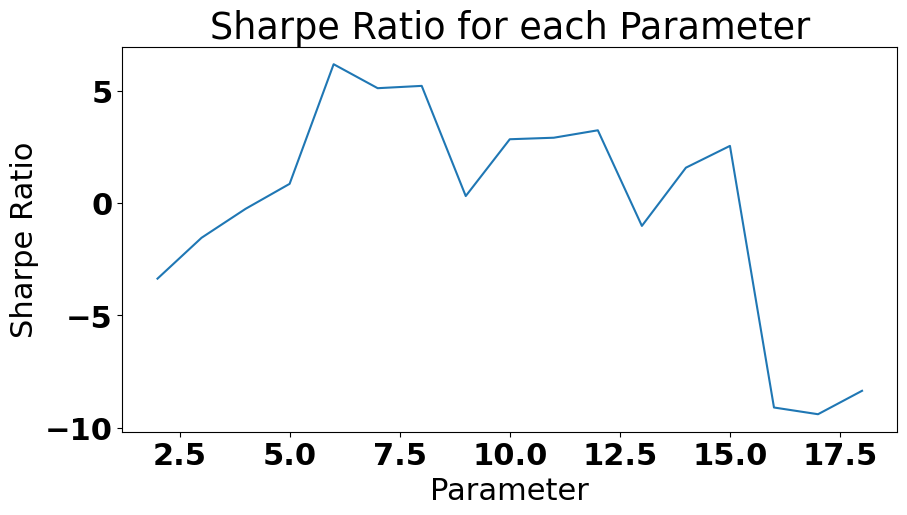

In [114]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

def backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage):
  df = ma_calc(df, n)
  in_position = False
  daily_profits = []
  capital = starting_capital
  total_profit = 0
  num_trades = 0
  wins = []
  losses = []

  for day in np.unique(df.index.date):
    df_day = df[df.index.date == day]
    profits = []
    for index, row in df_day.iterrows():
      volume_limit = row.Volume * volume_percentage  # Set volume limit as a percentage of daily volume
      if not in_position:
        if row.Close > row.sma and row.Volume > volume_limit:
          buyprice = row.Close
          investment = min(max(capital * volume_percentage, lower_cap), upper_cap)  # Investment per trade
          if investment * buyprice > capital * leverage:
            continue  # Skip if not enough capital
          capital -= investment * buyprice * (1 + transaction_cost)  # Deduct investment and transaction cost from capital
          in_position = True

      if in_position:
        if row.Close < row.sma or row.Close < buyprice * (1 - stop_loss):
          profit = (row.Close - buyprice) / buyprice
          profits.append(profit)
          capital += investment * row.Close * (1 - transaction_cost)  # Add selling proceeds after transaction cost to capital
          in_position = False
          num_trades += 1
          if profit > 0:
            wins.append(profit)
          else:
            losses.append(profit)

    daily_profits.append(sum(profits))

  # Calculate metrics
  daily_profits = pd.Series(daily_profits)
  hit_rate = (daily_profits > 0).mean()
  profit_factor = daily_profits[daily_profits > 0].sum() / -daily_profits[daily_profits < 0].sum()
  sharpe_ratio = np.sqrt(len(df)) * daily_profits.mean() / daily_profits.std()
  sortino_ratio = np.sqrt(len(df)) * daily_profits.mean() / daily_profits[daily_profits < 0].std()
  max_drawdown = np.min(daily_profits)
  total_profit = capital - starting_capital
  profit_percentage = (total_profit / starting_capital) * 100
  avg_win_to_avg_loss_ratio = np.mean(wins) / np.mean(losses)

  return hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades

# Initialize a dictionary to store metrics for each parameter
metrics_dict = {}

for n in range(2, 19):
  hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades = backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage)  # replace volume_limit with volume_percentage
  print(f"For parameter: {n}, Hit Rate: {hit_rate}, Profit Factor: {profit_factor}, Sharpe Ratio: {sharpe_ratio}, Max Drawdown: {max_drawdown}, Total Profit: {total_profit}, Profit Percentage: {profit_percentage}%, Average Win to Average Loss ratio: {avg_win_to_avg_loss_ratio}, Sortino Ratio: {sortino_ratio}, Number of Trades: {num_trades}")
  metrics_dict[n] = (hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades)

# Find the parameter with maximum Sharpe Ratio
max_sharpe_param = max(metrics_dict, key=lambda x: metrics_dict[x][2])
print(f"The parameter with maximum Sharpe Ratio is: {max_sharpe_param}")

# Add the feature with optimized value
df = ma_calc(df, max_sharpe_param)

# Plot the Sharpe Ratios
plt.figure(figsize=(10,5))
plt.plot(list(metrics_dict.keys()), [metrics_dict[p][2] for p in metrics_dict])
plt.xlabel('Parameter')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio for each Parameter')
plt.show()


**EMA**

For parameter: 2, Hit Rate: 0.030303030303030304, Profit Factor: 0.6065578170911899, Sharpe Ratio: -2.6232684707921794, Max Drawdown: -0.1338360049306812, Total Profit: -1018.484999999986, Profit Percentage: -10.18484999999986%, Average Win to Average Loss ratio: -1.0052131160588464, Sortino Ratio: -0.834522707993106, Number of Trades: 18
For parameter: 3, Hit Rate: 0.045454545454545456, Profit Factor: 0.8943677948141471, Sharpe Ratio: -0.7281312808462951, Max Drawdown: -0.10315519973808786, Total Profit: -785.6499999999724, Profit Percentage: -7.856499999999723%, Average Win to Average Loss ratio: -1.5931127614182394, Sortino Ratio: -0.3702806942663692, Number of Trades: 30
For parameter: 4, Hit Rate: 0.030303030303030304, Profit Factor: 0.9759064131926828, Sharpe Ratio: -0.16415359281087996, Max Drawdown: -0.12083681034482241, Total Profit: -799.3310797184586, Profit Percentage: -7.993310797184586%, Average Win to Average Loss ratio: -3.05981813233098, Sortino Ratio: -0.1119497761172

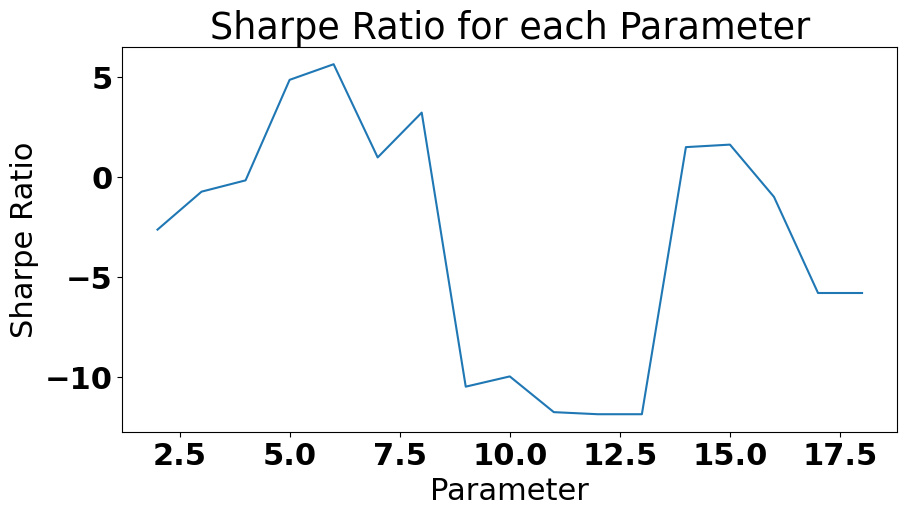

In [115]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

def backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage):
  df = ema_calc(df, n)
  in_position = False
  daily_profits = []
  capital = starting_capital
  net_profit_loss = 0
  num_trades = 0
  wins = []
  losses = []

  for day in np.unique(df.index.date):
    df_day = df[df.index.date == day]
    profits = []
    for index, row in df_day.iterrows():
      volume_limit = row.Volume * volume_percentage  # Set volume limit as a percentage of daily volume
      if not in_position:
        if row.Close > row.ema and row.Volume > volume_limit:
          buyprice = row.Close
          investment = min(max(capital * volume_percentage, lower_cap), upper_cap)  # Investment per trade
          if investment * buyprice > capital * leverage:
            continue  # Skip if not enough capital
          capital -= investment * buyprice * (1 + transaction_cost)  # Deduct investment and transaction cost from capital
          in_position = True

      if in_position:
        if row.Close < row.ema or row.Close < buyprice * (1 - stop_loss):
          profit = (row.Close - buyprice) / buyprice
          profits.append(profit)
          capital += investment * row.Close * (1 - transaction_cost)  # Add selling proceeds after transaction cost to capital
          in_position = False
          num_trades += 1
          if profit > 0:
            wins.append(profit)
          else:
            losses.append(profit)

    daily_profits.append(sum(profits))

  # Calculate metrics
  daily_profits = pd.Series(daily_profits)
  hit_rate = (daily_profits > 0).mean()
  profit_factor = daily_profits[daily_profits > 0].sum() / -daily_profits[daily_profits < 0].sum()
  sharpe_ratio = np.sqrt(len(df)) * daily_profits.mean() / daily_profits.std()
  sortino_ratio = np.sqrt(len(df)) * daily_profits.mean() / daily_profits[daily_profits < 0].std()
  max_drawdown = np.min(daily_profits)
  total_profit = capital - starting_capital
  profit_percentage = (total_profit / starting_capital) * 100
  avg_win_to_avg_loss_ratio = np.mean(wins) / np.mean(losses)

  return hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades

# Initialize a dictionary to store metrics for each parameter
metrics_dict = {}

for n in range(2, 19):
  hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades = backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage)  # replace volume_limit with volume_percentage
  print(f"For parameter: {n}, Hit Rate: {hit_rate}, Profit Factor: {profit_factor}, Sharpe Ratio: {sharpe_ratio}, Max Drawdown: {max_drawdown}, Total Profit: {total_profit}, Profit Percentage: {profit_percentage}%, Average Win to Average Loss ratio: {avg_win_to_avg_loss_ratio}, Sortino Ratio: {sortino_ratio}, Number of Trades: {num_trades}")
  metrics_dict[n] = (hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades)

# Find the parameter with maximum Sharpe Ratio
max_sharpe_param = max(metrics_dict, key=lambda x: metrics_dict[x][2])
print(f"The parameter with maximum Sharpe Ratio is: {max_sharpe_param}")

# Add the feature with optimized value
df = ema_calc(df, max_sharpe_param)

# Plot the Sharpe Ratios
plt.figure(figsize=(10,5))
plt.plot(list(metrics_dict.keys()), [metrics_dict[p][2] for p in metrics_dict])
plt.xlabel('Parameter')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio for each Parameter')
plt.show()


**Long short EMA**

For parameters: 19 and 2, Hit Rate: 0.030303030303030304, Profit Factor: 0.820021167501057, Sharpe Ratio: -1.3211399982158538, Max Drawdown: -0.11109607131446551, Total Profit: -759.1873471199851, Profit Percentage: -7.591873471199852%, Average Win to Average Loss ratio: -3.859094875097026, Sortino Ratio: -0.9289822292816613, Number of Trades: 17
For parameters: 19 and 3, Hit Rate: 0.045454545454545456, Profit Factor: 1.1362861538786067, Sharpe Ratio: 0.9409591410663131, Max Drawdown: -0.10819247084988944, Total Profit: -97.05158432200369, Profit Percentage: -0.9705158432200369%, Average Win to Average Loss ratio: -4.241304942546795, Sortino Ratio: 0.727846569007469, Number of Trades: 19
For parameters: 19 and 4, Hit Rate: 0.045454545454545456, Profit Factor: 1.3083657734429777, Sharpe Ratio: 1.6155607757648542, Max Drawdown: -0.11399967177904159, Total Profit: 174.77565459601828, Profit Percentage: 1.747756545960183%, Average Win to Average Loss ratio: -4.202624653182449, Sortino Rati

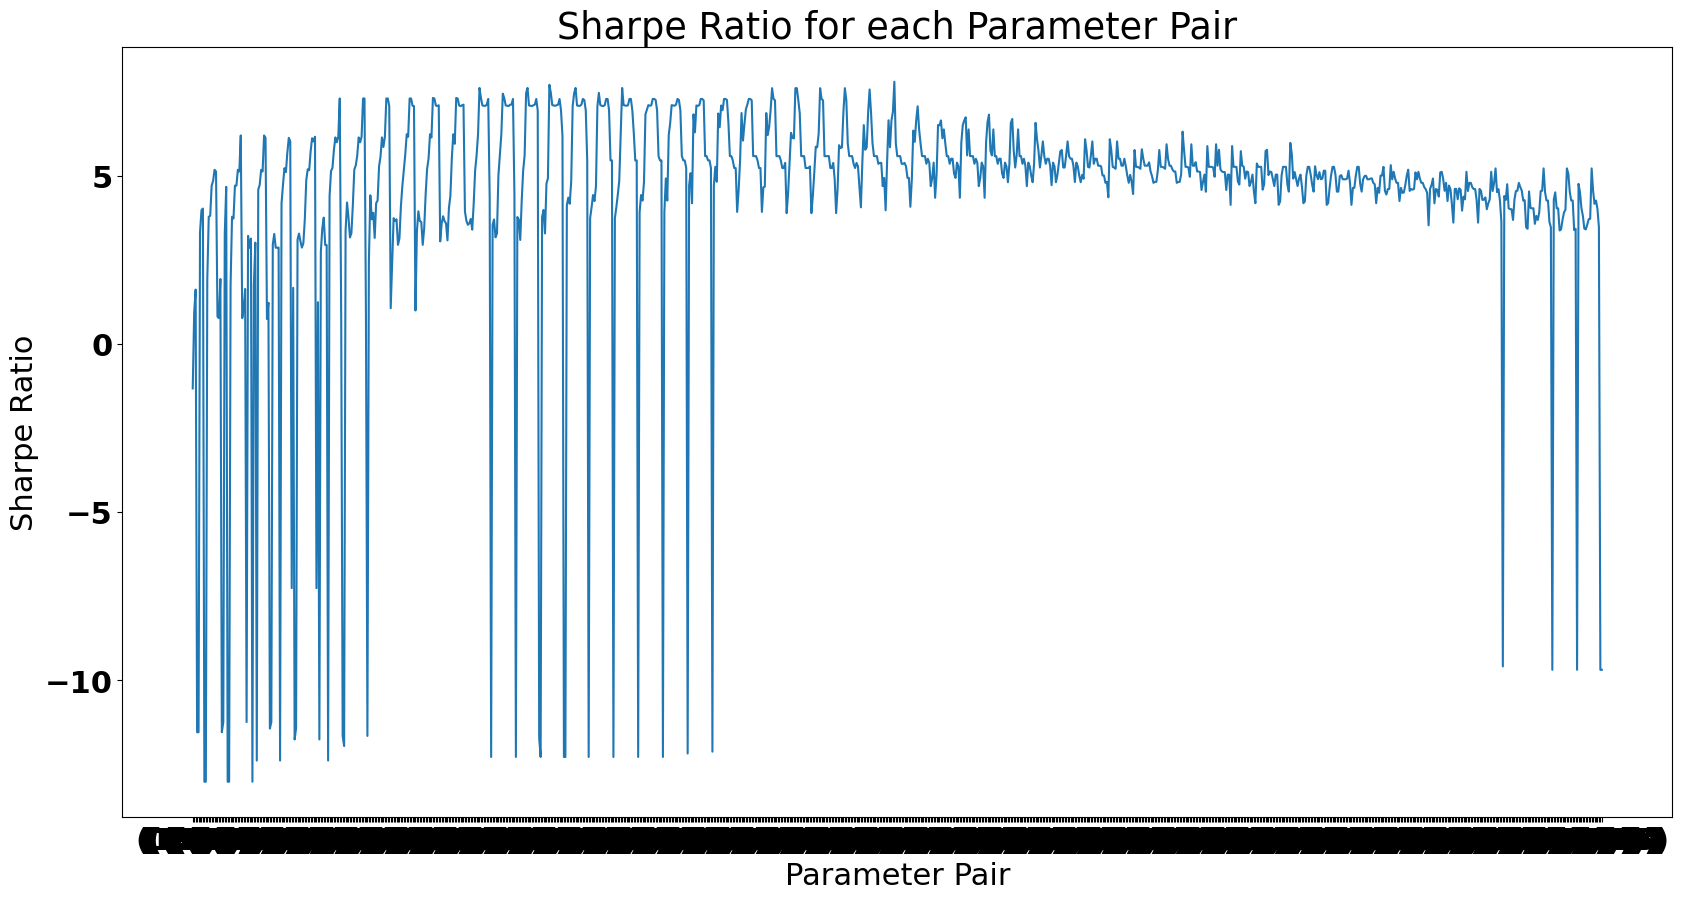

In [116]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

def backtest(df, m, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage):
  df = longshort_ema_calc(df, m, n)
  in_position = False
  daily_profits = []
  capital = starting_capital
  net_profit_loss = 0
  num_trades = 0
  wins = []
  losses = []

  for day in np.unique(df.index.date):
    df_day = df[df.index.date == day]
    profits = []
    for index, row in df_day.iterrows():
      volume_limit = row.Volume * volume_percentage  # Set volume limit as a percentage of daily volume
      if not in_position:
        if row.ema_short > row.ema_long and row.Volume > volume_limit:
          buyprice = row.Close
          investment = min(max(capital * volume_percentage, lower_cap), upper_cap)  # Investment per trade
          if investment * buyprice > capital * leverage:
            continue  # Skip if not enough capital
          capital -= investment * buyprice * (1 + transaction_cost)  # Deduct investment and transaction cost from capital
          in_position = True

      if in_position:
        if row.ema_short < row.ema_long or row.Close < buyprice * (1 - stop_loss):
          profit = (row.Close - buyprice) / buyprice
          profits.append(profit)
          capital += investment * row.Close * (1 - transaction_cost)  # Add selling proceeds after transaction cost to capital
          in_position = False
          num_trades += 1
          if profit > 0:
            wins.append(profit)
          else:
            losses.append(profit)

    daily_profits.append(sum(profits))

  # Calculate metrics
  daily_profits = pd.Series(daily_profits)
  hit_rate = (daily_profits > 0).mean()
  profit_factor = daily_profits[daily_profits > 0].sum() / -daily_profits[daily_profits < 0].sum()
  sharpe_ratio = np.sqrt(len(df)) * daily_profits.mean() / daily_profits.std()
  sortino_ratio = np.sqrt(len(df)) * daily_profits.mean() / daily_profits[daily_profits < 0].std()
  max_drawdown = np.min(daily_profits)
  total_profit = capital - starting_capital
  profit_percentage = (total_profit / starting_capital) * 100
  avg_win_to_avg_loss_ratio = np.mean(wins) / np.mean(losses)

  return hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades

# Initialize a dictionary to store metrics for each parameter pair
metrics_dict = {}

for m in range(19, 76):
  for n in range(2, 19):
    if m != n:
      hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades = backtest(df, m, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage)
      print(f"For parameters: {m} and {n}, Hit Rate: {hit_rate}, Profit Factor: {profit_factor}, Sharpe Ratio: {sharpe_ratio}, Max Drawdown: {max_drawdown}, Total Profit: {total_profit}, Profit Percentage: {profit_percentage}%, Average Win to Average Loss ratio: {avg_win_to_avg_loss_ratio}, Sortino Ratio: {sortino_ratio}, Number of Trades: {num_trades}")
      metrics_dict[(m, n)] = (hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades)

# Find the parameter pair with maximum Sharpe Ratio
max_sharpe_param = max(metrics_dict, key=lambda x: metrics_dict[x][2])
print(f"The parameter pair with maximum Sharpe Ratio is: {max_sharpe_param}")

m, n = max_sharpe_param
df = longshort_ema_calc(df, m, n) #adding the feature with optimized parameter

# Plot the Sharpe Ratios
plt.figure(figsize=(20,10))
plt.plot([str(k) for k in metrics_dict.keys()], [metrics_dict[p][2] for p in metrics_dict])
plt.xlabel('Parameter Pair')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio for each Parameter Pair')
plt.show()


**RSI**

For parameter: 2, Hit Rate: 0.045454545454545456, Profit Factor: 0.7632390534123018, Sharpe Ratio: -1.863800523409665, Max Drawdown: -0.06817697551405683, Total Profit: -1026.7821691888093, Profit Percentage: -10.267821691888093%, Average Win to Average Loss ratio: -0.7081695629387597, Sortino Ratio: -1.2393409485528624, Number of Trades: 34
For parameter: 3, Hit Rate: 0.030303030303030304, Profit Factor: 0.5549343358781715, Sharpe Ratio: -3.6343503962146424, Max Drawdown: -0.1054386259147794, Total Profit: -1423.504999999981, Profit Percentage: -14.235049999999811%, Average Win to Average Loss ratio: -0.601066412163985, Sortino Ratio: -3.1550407826980784, Number of Trades: 22
For parameter: 4, Hit Rate: 0.030303030303030304, Profit Factor: 0.5597772528096188, Sharpe Ratio: -3.4011264197311686, Max Drawdown: -0.11313246162592384, Total Profit: -1143.1999999999935, Profit Percentage: -11.431999999999935%, Average Win to Average Loss ratio: -0.8396658792144283, Sortino Ratio: -1.54908825

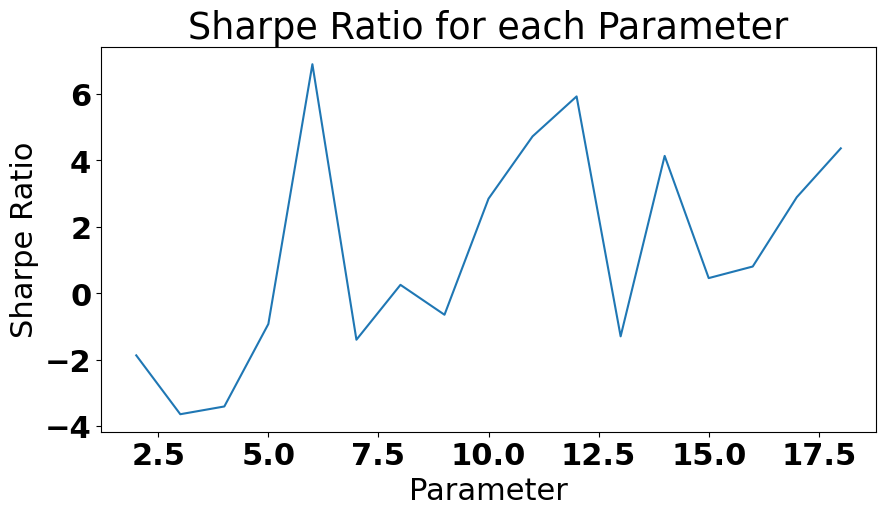

In [117]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

def backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage):
  df = rsi_calc(df, n)
  in_position = False
  daily_profits = []
  capital = starting_capital
  net_profit_loss = 0
  num_trades = 0
  wins = []
  losses = []

  for day in np.unique(df.index.date):
    df_day = df[df.index.date == day]
    profits = []
    for index, row in df_day.iterrows():
      volume_limit = row.Volume * volume_percentage  # Set volume limit as a percentage of daily volume
      if not in_position:
        if row.rsi < 30 and row.Volume > volume_limit:  # RSI is less than 30, oversold condition
          buyprice = row.Close
          investment = min(max(capital * volume_percentage, lower_cap), upper_cap)  # Investment per trade
          if investment * buyprice > capital * leverage:
            continue  # Skip if not enough capital
          capital -= investment * buyprice * (1 + transaction_cost)  # Deduct investment and transaction cost from capital
          in_position = True

      if in_position:
        if row.rsi > 70 or row.Close < buyprice * (1 - stop_loss):  # RSI is greater than 70, overbought condition
          profit = (row.Close - buyprice) / buyprice
          profits.append(profit)
          capital += investment * row.Close * (1 - transaction_cost)  # Add selling proceeds after transaction cost to capital
          in_position = False
          num_trades += 1
          if profit > 0:
            wins.append(profit)
          else:
            losses.append(profit)

    daily_profits.append(sum(profits))

  # Calculate metrics
  daily_profits = pd.Series(daily_profits)
  hit_rate = (daily_profits > 0).mean()
  profit_factor = daily_profits[daily_profits > 0].sum() / -daily_profits[daily_profits < 0].sum()
  sharpe_ratio = np.sqrt(len(df)) * daily_profits.mean() / daily_profits.std()
  sortino_ratio = np.sqrt(len(df)) * daily_profits.mean() / daily_profits[daily_profits < 0].std()
  max_drawdown = np.min(daily_profits)
  total_profit = capital - starting_capital
  profit_percentage = (total_profit / starting_capital) * 100
  avg_win_to_avg_loss_ratio = np.mean(wins) / np.mean(losses)

  return hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades

# Initialize a dictionary to store metrics for each parameter
metrics_dict = {}

for n in range(2, 19):
  hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades = backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage)  # replace volume_limit with volume_percentage
  print(f"For parameter: {n}, Hit Rate: {hit_rate}, Profit Factor: {profit_factor}, Sharpe Ratio: {sharpe_ratio}, Max Drawdown: {max_drawdown}, Total Profit: {total_profit}, Profit Percentage: {profit_percentage}%, Average Win to Average Loss ratio: {avg_win_to_avg_loss_ratio}, Sortino Ratio: {sortino_ratio}, Number of Trades: {num_trades}")
  metrics_dict[n] = (hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades)

# Find the parameter with maximum Sharpe Ratio
max_sharpe_param = max(metrics_dict, key=lambda x: metrics_dict[x][2])
print(f"The parameter with maximum Sharpe Ratio is: {max_sharpe_param}")

df = rsi_calc(df, max_sharpe_param) #adding the feature with optimized parameter

# Plot the Sharpe Ratios
plt.figure(figsize=(10,5))
plt.plot(list(metrics_dict.keys()), [metrics_dict[p][2] for p in metrics_dict])
plt.xlabel('Parameter')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio for each Parameter')
plt.show()


**Bollinger Bands**

For parameter: 2, Hit Rate: 0.0, Profit Factor: 0.0, Sharpe Ratio: -8.763543607399766, Max Drawdown: -0.09196740395809086, Total Profit: -9720.809999999994, Profit Percentage: -97.20809999999994%, Average Win to Average Loss ratio: nan, Sortino Ratio: -42.932585175072205, Number of Trades: 4
For parameter: 3, Hit Rate: 0.0, Profit Factor: 0.0, Sharpe Ratio: -8.763543607399766, Max Drawdown: -0.09196740395809086, Total Profit: -9720.809999999994, Profit Percentage: -97.20809999999994%, Average Win to Average Loss ratio: nan, Sortino Ratio: -42.932585175072205, Number of Trades: 4
For parameter: 4, Hit Rate: 0.0, Profit Factor: 0.0, Sharpe Ratio: -8.763543607399766, Max Drawdown: -0.09196740395809086, Total Profit: -9720.809999999994, Profit Percentage: -97.20809999999994%, Average Win to Average Loss ratio: nan, Sortino Ratio: -42.932585175072205, Number of Trades: 4
For parameter: 5, Hit Rate: 0.0, Profit Factor: 0.0, Sharpe Ratio: -8.763543607399766, Max Drawdown: -0.09196740395809086

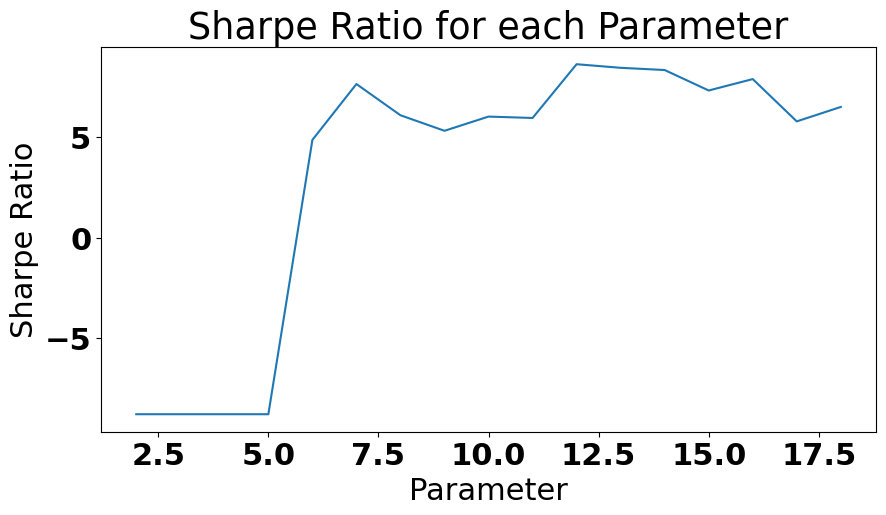

In [118]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

def backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage):
  df = bb_calc(df, n)
  in_position = False
  daily_profits = []
  capital = starting_capital
  net_profit_loss = 0
  num_trades = 0
  wins = []
  losses = []

  for day in np.unique(df.index.date):
    df_day = df[df.index.date == day]
    profits = []
    for index, row in df_day.iterrows():
      volume_limit = row.Volume * volume_percentage  # Set volume limit as a percentage of daily volume
      if not in_position:
        if row.Close > row.lower_bb and row.Volume > volume_limit:  # Price is above lower Bollinger Band
          buyprice = row.Close
          investment = min(max(capital * volume_percentage, lower_cap), upper_cap)  # Investment per trade
          if investment * buyprice > capital * leverage:
            continue  # Skip if not enough capital
          capital -= investment * buyprice * (1 + transaction_cost)  # Deduct investment and transaction cost from capital
          in_position = True

      if in_position:
        if row.Close > row.upper_bb or row.Close < buyprice * (1 - stop_loss):  # Price is above upper Bollinger Band or stop loss is hit
          profit = (row.Close - buyprice) / buyprice
          profits.append(profit)
          capital += investment * row.Close * (1 - transaction_cost)  # Add selling proceeds after transaction cost to capital
          in_position = False
          num_trades += 1
          if profit > 0:
            wins.append(profit)
          else:
            losses.append(profit)

    daily_profits.append(sum(profits))

  # Calculate metrics
  daily_profits = pd.Series(daily_profits)
  hit_rate = (daily_profits > 0).mean()
  profit_factor = daily_profits[daily_profits > 0].sum() / -daily_profits[daily_profits < 0].sum()
  sharpe_ratio = np.sqrt(len(df)) * daily_profits.mean() / daily_profits.std()
  sortino_ratio = np.sqrt(len(df)) * daily_profits.mean() / daily_profits[daily_profits < 0].std()
  max_drawdown = np.min(daily_profits)
  total_profit = capital - starting_capital
  profit_percentage = (total_profit / starting_capital) * 100
  avg_win_to_avg_loss_ratio = np.mean(wins) / np.mean(losses)

  return hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades

# Initialize a dictionary to store metrics for each parameter
metrics_dict = {}

for n in range(2, 19):
  hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades = backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage)  # replace volume_limit with volume_percentage
  print(f"For parameter: {n}, Hit Rate: {hit_rate}, Profit Factor: {profit_factor}, Sharpe Ratio: {sharpe_ratio}, Max Drawdown: {max_drawdown}, Total Profit: {total_profit}, Profit Percentage: {profit_percentage}%, Average Win to Average Loss ratio: {avg_win_to_avg_loss_ratio}, Sortino Ratio: {sortino_ratio}, Number of Trades: {num_trades}")
  metrics_dict[n] = (hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades)

# Find the parameter with maximum Sharpe Ratio
max_sharpe_param = max(metrics_dict, key=lambda x: metrics_dict[x][2])
print(f"The parameter with maximum Sharpe Ratio is: {max_sharpe_param}")

df = bb_calc(df, max_sharpe_param) #adding the feature with optimized parameter

# Plot the Sharpe Ratios
plt.figure(figsize=(10,5))
plt.plot(list(metrics_dict.keys()), [metrics_dict[p][2] for p in metrics_dict])
plt.xlabel('Parameter')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio for each Parameter')
plt.show()


**ADX**

For parameter: 2, Hit Rate: 0.12121212121212122, Profit Factor: 3.3472833718721384, Sharpe Ratio: 10.092061967157257, Max Drawdown: -0.05836631924409913, Total Profit: 2024.9273116154927, Profit Percentage: 20.249273116154928%, Average Win to Average Loss ratio: -2.377865953846522, Sortino Ratio: 11.127027519847722, Number of Trades: 45
For parameter: 3, Hit Rate: 0.12121212121212122, Profit Factor: 2.8789483030381953, Sharpe Ratio: 9.501960256280153, Max Drawdown: -0.05429589445752396, Total Profit: 1617.4216867717296, Profit Percentage: 16.174216867717295%, Average Win to Average Loss ratio: -2.427198048858798, Sortino Ratio: 10.961930626130654, Number of Trades: 39
For parameter: 4, Hit Rate: 0.09090909090909091, Profit Factor: 2.2183584058129275, Sharpe Ratio: 6.4342708594409785, Max Drawdown: -0.07609907654355824, Total Profit: 1465.4521412389404, Profit Percentage: 14.654521412389403%, Average Win to Average Loss ratio: -2.945249527527821, Sortino Ratio: 8.141149324264319, Number

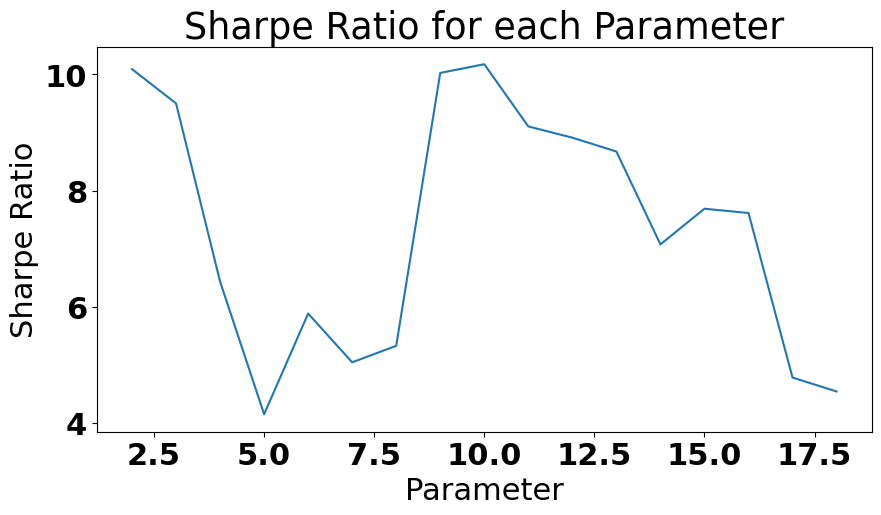

In [119]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

def adx_calc(df, n):
    df['hl_diff'] = df['High'] - df['Low']
    df['hc_diff'] = abs(df['High'] - df['Close'].shift(1))
    df['lc_diff'] = abs(df['Low'] - df['Close'].shift(1))
    df['tr'] = df[['hl_diff', 'hc_diff', 'lc_diff']].max(axis=1)
    df['+dm'] = np.where((df['High'] > df['High'].shift(1)) & (df['High'] - df['High'].shift(1) > df['Low'].shift(1) - df['Low']), df['High'] - df['High'].shift(1), 0)
    df['-dm'] = np.where((df['Low'] < df['Low'].shift(1)) & (df['High'].shift(1) - df['High'] < df['Low'].shift(1) - df['Low']), df['Low'].shift(1) - df['Low'], 0)
    df['tr_ema'] = df['tr'].ewm(span=n, adjust=False).mean()
    df['+dm_ema'] = df['+dm'].ewm(span=n, adjust=False).mean()
    df['-dm_ema'] = df['-dm'].ewm(span=n, adjust=False).mean()
    df['+di'] = (df['+dm_ema'] / df['tr_ema']) * 100
    df['-di'] = (df['-dm_ema'] / df['tr_ema']) * 100
    df['dx'] = (abs(df['+di'] - df['-di']) / (df['+di'] + df['-di'])) * 100
    df['adx'] = df['dx'].rolling(window=n).mean()

    return df

def backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage):
  df = adx_calc(df, n)
  in_position = False
  daily_profits = []
  capital = starting_capital
  net_profit_loss = 0
  num_trades = 0
  wins = []
  losses = []

  for day in np.unique(df.index.date):
    df_day = df[df.index.date == day]
    profits = []
    for index, row in df_day.iterrows():
      volume_limit = row.Volume * volume_percentage  # Set volume limit as a percentage of daily volume
      if not in_position:
        if row['+di'] > row['-di'] and row.adx > 25 and row.Volume > volume_limit:
          buyprice = row.Close
          investment = min(max(capital * volume_percentage, lower_cap), upper_cap)  # Investment per trade
          if investment * buyprice > capital * leverage:
            continue  # Skip if not enough capital
          capital -= investment * buyprice * (1 + transaction_cost)  # Deduct investment and transaction cost from capital
          in_position = True

      if in_position:
        if row['+di'] < row['-di'] or row.Close < buyprice * (1 - stop_loss):
          profit = (row.Close - buyprice) / buyprice
          profits.append(profit)
          capital += investment * row.Close * (1 - transaction_cost)  # Add selling proceeds after transaction cost to capital
          in_position = False
          num_trades += 1
          if profit > 0:
            wins.append(profit)
          else:
            losses.append(profit)

    daily_profits.append(sum(profits))

  # Calculate metrics
  daily_profits = pd.Series(daily_profits)
  hit_rate = (daily_profits > 0).mean()
  profit_factor = daily_profits[daily_profits > 0].sum() / -daily_profits[daily_profits < 0].sum()
  sharpe_ratio = np.sqrt(len(df)) * daily_profits.mean() / daily_profits.std()
  sortino_ratio = np.sqrt(len(df)) * daily_profits.mean() / daily_profits[daily_profits < 0].std()
  max_drawdown = np.min(daily_profits)
  total_profit = capital - starting_capital
  profit_percentage = (total_profit / starting_capital) * 100
  avg_win_to_avg_loss_ratio = np.mean(wins) / np.mean(losses)

  return hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades


# Initialize a dictionary to store metrics for each parameter
metrics_dict = {}

for n in range(2, 19):
  hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades = backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage)  # replace volume_limit with volume_percentage
  print(f"For parameter: {n}, Hit Rate: {hit_rate}, Profit Factor: {profit_factor}, Sharpe Ratio: {sharpe_ratio}, Max Drawdown: {max_drawdown}, Total Profit: {total_profit}, Profit Percentage: {profit_percentage}%, Average Win to Average Loss ratio: {avg_win_to_avg_loss_ratio}, Sortino Ratio: {sortino_ratio}, Number of Trades: {num_trades}")
  metrics_dict[n] = (hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades)


# Find the parameter with maximum Sharpe Ratio
max_sharpe_param = max(metrics_dict, key=lambda x: metrics_dict[x][2])
print(f"The parameter with maximum Sharpe Ratio is: {max_sharpe_param}")

df = adx_calc(df, max_sharpe_param) #adding the feature with optimized parameter

# Plot the Sharpe Ratios
plt.figure(figsize=(10,5))
plt.plot(list(metrics_dict.keys()), [metrics_dict[p][2] for p in metrics_dict])
plt.xlabel('Parameter')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio for each Parameter')
plt.show()


**Based on Local Extrema**

In [86]:
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema

def find_extrema(s):
    c_min = lambda x, y: np.less(x, y)
    c_max = lambda x, y: np.greater(x, y)

    minima_idx = argrelextrema(s.values, c_min)[0]
    maxima_idx = argrelextrema(s.values, c_max)[0]

    signals = pd.Series(0, index=s.index)
    signals.iloc[minima_idx] = 1  # Buy signal
    signals.iloc[maxima_idx] = -1  # Sell signal

    return signals

def backtest(df, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage):
    df['signals'] = find_extrema(df['Close'])

    in_position = False
    daily_profits = []
    capital = starting_capital
    net_profit_loss = 0
    num_trades = 0
    wins = []
    losses = []
    buyprice=0


    for day in np.unique(df.index.date):
        df_day = df[df.index.date == day]
        profits = []
        for index, row in df_day.iterrows():
            volume_limit = row.Volume * volume_percentage
            if not in_position and row.signals == 1:
                buyprice = row.Close
                investment = min(max(capital * volume_percentage, lower_cap), upper_cap)
                if investment * buyprice > capital * leverage:
                    continue
                capital -= investment * buyprice * (1 + transaction_cost)
                in_position = True

            if in_position and row.signals == -1:
                profit = (row.Close - buyprice) / buyprice
                profits.append(profit)
                capital += investment * row.Close * (1 - transaction_cost)
                in_position = False
                num_trades += 1
                if profit > 0:
                    wins.append(profit)
                else:
                    losses.append(profit)

        daily_profits.append(sum(profits))

    daily_profits = pd.Series(daily_profits)
    hit_rate = (daily_profits > 0).mean()
    profit_factor = daily_profits[daily_profits > 0].sum() / -daily_profits[daily_profits < 0].sum()
    sharpe_ratio = np.sqrt(len(df)) * daily_profits.mean() / daily_profits.std()
    sortino_ratio = np.sqrt(len(df)) * daily_profits.mean() / daily_profits[daily_profits < 0].std()
    max_drawdown = np.min(daily_profits)
    total_profit = capital - starting_capital
    profit_percentage = (total_profit / starting_capital) * 100
    avg_win_to_avg_loss_ratio = np.mean(wins) / np.mean(losses)

    return hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades

# Now you can call the backtest function with your parameters
hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades = backtest(df, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage)

print(f"Hit Rate: {hit_rate}, Profit Factor: {profit_factor}, Sharpe Ratio: {sharpe_ratio}, Max Drawdown: {max_drawdown}, Total Profit: {total_profit}, Profit Percentage: {profit_percentage}%, Average Win to Average Loss ratio: {avg_win_to_avg_loss_ratio}, Sortino Ratio: {sortino_ratio}, Number of Trades: {num_trades}")


Hit Rate: 0.0, Profit Factor: nan, Sharpe Ratio: nan, Max Drawdown: 0, Total Profit: 0, Profit Percentage: 0.0%, Average Win to Average Loss ratio: nan, Sortino Ratio: nan, Number of Trades: 0


# **Report Obtained for each Indicator**
**The reports include these:**

(i) Net profit

(ii) Profit Factor

(iii) Sharpe Ratio

(iv) Hit Rate/Win rate

(v) Max Drawdown

(vi) Net Profit/ loss

(vii) Average Win to Average Loss ratio

(viii) Sortino Ratio

(ix)Number of Trades

In [67]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'sma', 'sma_short',
       'sma_long', 'ema', 'ema_short', 'ema_long', 'rsi', 'std', 'upper_bb',
       'lower_bb', 'vwap', 'hl_diff', 'hc_diff', 'lc_diff', 'tr', '+dm', '-dm',
       'tr_ema', '+dm_ema', '-dm_ema', '+di', '-di', 'dx', 'adx', 'hl_avg',
       'range', 'upper_band', 'lower_band', 'upper_band_final',
       'lower_band_final', 'supertrend', 'macd_line', 'signal_line',
       'macd_histogram'],
      dtype='object')

# **Report Obtained using MaxVote Strategy for all Indicators**

# **Plots and Vizualizations for selective Indicators**

In [50]:
df2=df.copy()
df2.reset_index(level=0, inplace=True)
df2.rename(columns={'index': 'Date'}, inplace=True)
# callable plotting function
def plot_df(columns, date_range):
    if columns:  # Check if any column is selected
        fig, ax = plt.subplots(figsize=(50, 20))  # Create a figure and a set of subplots
        df2.set_index('Date').loc[date_range[0]:date_range[1], list(columns)].plot(ax=ax)  # Plot on the specific axes
        ax.grid(True)
        ax.legend(fontsize="40")  # Increase the legend size

        font = {'weight' : 'bold',
                'size'   : 22}

        plt.rc('font', **font)
        plt.show()

# Getting column names from the dfFrame
column_names = [col for col in df2.columns.tolist() if col != 'Date']

# Here creating date range slider
dates = pd.date_range(df2['Date'].min(), df2['Date'].max(), freq='D')
options = [(date.strftime(' %d %b %Y '), date) for date in dates]
date_range_slider = SelectionRangeSlider(
    options=options,
    index=(0, len(options)-1),
    description='Dates',
    orientation='horizontal',
    layout={'width': '500px'}
)

# Plotting interactive plot
interact(plot_df, columns=SelectMultiple(options=column_names), date_range=date_range_slider)

interactive(children=(SelectMultiple(description='columns', options=('Open', 'High', 'Low', 'Close', 'Volume',…

<function __main__.plot_df(columns, date_range)>